<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [11]:
from pymongo import MongoClient
connection = MongoClient(
    host="research.cassee.dev:27017",
    username="read-shark",
    password="msr2021shark")

print(f"Databases present are {connection.list_database_names()}")

db = connection.smartshark_2_1

project = db.project.find_one({})

repos = list(db.vcs_system.find({'project_id':project['_id']}))

print(f"Found {len(repos)} repos")

commits = db.commit.count_documents({'vcs_system_id': {'$in': [x["_id"] for x in repos]}})

print(f"There are {commits} commits for {project['name']}")

Databases present are ['smartshark_2_1']
Found 1 repos
There are 7222 commits for commons-math


In [12]:
import pandas as pd
from bson.json_util import dumps
from json import loads
import bson
from matplotlib import pyplot as plt

In [13]:
db = connection['smartshark_2_1']
print(db)

Database(MongoClient(host=['research.cassee.dev:27017'], document_class=dict, tz_aware=False, connect=True), 'smartshark_2_1')


In [14]:
def convert_object_ids(df, keys):
    for x in keys:
        df[x] = (df.apply(lambda y: loads(dumps(y[x] if type(y[x]) == bson.objectid.ObjectId else {'$oid': None}))['$oid'], axis=1))


In [6]:
# Get the people dataset and convert the ObjectIds to strings
df_people = pd.DataFrame(list(db.people.find({})))
convert_object_ids(df_people, ['_id'])

In [7]:
# Get the project dataset and convert the ObjectIds to strings
df_project = pd.DataFrame(list(db.project.find({})))
convert_object_ids(df_project, ['_id'])

In [16]:
# Get the PR dataset and convert the ObjectIds to strings
df_pull_request = pd.DataFrame(list(db.pull_request.find({})))
convert_object_ids(df_pull_request, [
    '_id',
    # 'assignee_id',
    'creator_id',
    # 'merge_commit_id',
    'pull_request_system_id',
    # 'requested_reviewer_ids',
    # 'source_commit_id',
    # 'target_commit_id'
])
df_pull_request.head(1)

,_id,pull_request_system_id,external_id,title,description,is_draft,is_locked,author_association,created_at,updated_at,...,source_branch,source_commit_sha,target_repo_url,target_branch,target_commit_sha,source_commit_id,target_commit_id,merge_commit_id,assignee_id,lock_reason
0,5ff1886f3fba52c925be8927,5ff1886a3fba52c925be8926,93,RetrieveEngine: remove superfluous space in error,,False,False,CONTRIBUTOR,2020-04-05 10:26:16,2020-04-05 12:24:21,...,patch-1,bb8cfa726cb93f8f77b59125e80e06cf2fc1b7f6,https://github.com/apache/ant-ivy,master,87de65450494a13a0ce2a86bd21742e2ac8c999a,NaN,NaN,NaN,NaN,NaN


In [17]:
# Get the PR_review dataset and convert the ObjectIds to strings
df_pull_request_review = pd.DataFrame(list(db.pull_request_review.find({})))
convert_object_ids(df_pull_request_review, [
    '_id',
    'creator_id',
    # 'pull_request_commit_id',
    'pull_request_id'
])
df_pull_request_review.head(1)

,_id,pull_request_id,external_id,state,description,creator_id,submitted_at,author_association,commit_sha,pull_request_commit_id
0,5ff188803fba52c925be898d,5ff1887f3fba52c925be898c,143337164,APPROVED,"The code looks good, ASN.1-like encoding is a ...",5ff18872c26a57681e7b6d2b,2018-08-03 21:41:31,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN


In [57]:
# Get the PR_review dataset and convert the ObjectIds to strings
df_pull_request_event = pd.DataFrame(list(db.pull_request_event.find({})))
convert_object_ids(df_pull_request_event, [
    '_id',
    'author_id',
    # 'commit_id',
    # 'pull_request_commit_id',
    'pull_request_id'
])
df_pull_request_event.head(1)

,_id,pull_request_id,external_id,created_at,author_id,commit_sha,commit_repo_url,event_type,additional_data,commit_id
0,5ff188713fba52c925be892a,5ff1886f3fba52c925be8927,3202397712,2020-04-05 12:24:20,59bc22dcf2a4565fe9cfa0a7,bb8cfa726cb93f8f77b59125e80e06cf2fc1b7f6,https://github.com/apache/ant-ivy,merged,{'performed_via_github_app': None},NaN


In [19]:
# Get the PR_review_system dataset
df_pull_request_system = pd.DataFrame(list(db.pull_request_system.find({})))
convert_object_ids(df_pull_request_system, [
    '_id',
    'project_id',
])
df_pull_request_system.head(1)

,_id,project_id,url,last_updated
0,5ff1886a3fba52c925be8926,58c8979e0da3ef6363ccb8de,https://api.github.com/repos/apache/ant-ivy/pulls,2021-01-03 10:03:38.742


In [20]:
# Create the same identifier so that we can join
df_pull_request['pull_request_id'] = df_pull_request['_id']
df_pull_request_review['pull_request_review_id']=df_pull_request_review['_id']
df_pull_request_system['pull_request_system_id']=df_pull_request_system['_id']

### Number of reviewers per project

In [42]:
# Join
df_review_project_list = pd.merge(df_pull_request_system, df_pull_request, on='pull_request_system_id')
df_reviewer_list = pd.merge(df_review_project_list, df_pull_request_review, on='pull_request_id')
df_reviewer_list.head(3)

,_id_x,project_id,url,last_updated,pull_request_system_id,_id_y,external_id_x,title,description_x,is_draft,...,_id,external_id_y,state_y,description_y,creator_id_y,submitted_at,author_association_y,commit_sha,pull_request_commit_id,pull_request_review_id
0,5ff1886a3fba52c925be8926,58c8979e0da3ef6363ccb8de,https://api.github.com/repos/apache/ant-ivy/pulls,2021-01-03 10:03:38.742,5ff1886a3fba52c925be8926,5ff1887f3fba52c925be898c,73,IVY-1104 Include attributes qualifiers in the ...,### Issue\r\n`${ivy.deps.changed}` is always `...,False,...,5ff188803fba52c925be898d,143337164,APPROVED,"The code looks good, ASN.1-like encoding is a ...",5ff18872c26a57681e7b6d2b,2018-08-03 21:41:31,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN,5ff188803fba52c925be898d
1,5ff1886a3fba52c925be8926,58c8979e0da3ef6363ccb8de,https://api.github.com/repos/apache/ant-ivy/pulls,2021-01-03 10:03:38.742,5ff1886a3fba52c925be8926,5ff1887f3fba52c925be898c,73,IVY-1104 Include attributes qualifiers in the ...,### Issue\r\n`${ivy.deps.changed}` is always `...,False,...,5ff188803fba52c925be898f,143344703,COMMENTED,,5ff1887dc26a57681e7b6ee1,2018-08-03 21:47:53,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN,5ff188803fba52c925be898f
2,5ff1886a3fba52c925be8926,58c8979e0da3ef6363ccb8de,https://api.github.com/repos/apache/ant-ivy/pulls,2021-01-03 10:03:38.742,5ff1886a3fba52c925be8926,5ff188843fba52c925be89c6,71,Ivy main/standalone: Patch to include 'makepom...,"Hello,\r\n\r\nI added the pomfile option to ma...",False,...,5ff188853fba52c925be89ca,107610203,COMMENTED,,5ff18875c26a57681e7b6d68,2018-03-28 09:46:39,MEMBER,5e814ad7a84ffb2a9d4df72fc801e9b8d6aa2f64,5ff188843fba52c925be89c7,5ff188853fba52c925be89ca


In [61]:
df_group_by_project = df_reviewer_list.groupby('project_id')
#print(df_group_by_project.get_group("58c8979e0da3ef6363ccb8de"))
df_group_by_project_stastic = df_group_by_project['creator_id_y'].nunique()
df_group_by_project_stastic.reset_index()

,project_id,creator_id_y
0,58bfd5860da3ef7cef464c78,9
1,58c8979e0da3ef6363ccb8de,5
2,5b0fa95e0da3ef431af80833,599
3,5b110ee90da3ef05a99f0de6,195
4,5b1f9fbb0da3ef49b7d0a480,10
...,...,...
67,608b9e8d4064fcb5083898b5,7
68,608c3a354064fcb5083898b6,68
69,60a24a6992d37bcecc65bf82,3
70,60a24a978d56179891397c71,4


### Review time per project

### Approve rate per project

In [56]:
# Get all the events closing a PR
df_closed_prs = df_pull_request_event.where(df_pull_request_event['event_type'] == 'closed').dropna(subset=['_id'])
df_closed_prs.head(3)

KeyError: 'event_type'

### Approved Pull Requests

In [11]:
df_approved_prs = df_pull_request_review.where(df_pull_request_review['state'] == 'APPROVED').dropna(subset=['_id'])
df_approved_prs.head(3)

,_id,pull_request_id,external_id,state,description,creator_id,submitted_at,author_association,commit_sha,pull_request_commit_id
0,5ff188803fba52c925be898d,5ff1887f3fba52c925be898c,143337164,APPROVED,"The code looks good, ASN.1-like encoding is a ...",5ff18872c26a57681e7b6d2b,2018-08-03 21:41:31,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN
37,5ff1919ecbcaee8d21c67e79,5ff1919ccbcaee8d21c67e75,489446018,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-16 09:32:52,CONTRIBUTOR,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,5ff1919dcbcaee8d21c67e76
38,5ff191a0cbcaee8d21c67e82,5ff1919ecbcaee8d21c67e7f,479608653,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-01 10:28:43,CONTRIBUTOR,c21157ad10224d78291b3433914847f9227f038d,5ff1919fcbcaee8d21c67e80


In [180]:
# Join
df_approved_prs__annotated_with_pr_creator = pd.merge(df_approved_prs, df_pull_request, on='pull_request_id')
df_approved_prs__annotated_with_pr_creator.head(3)

In [208]:
df_approved_prs__annotated_with_pr_creator.columns

Index(['_id_x', 'pull_request_id', 'external_id_x', 'state_x', 'description_x',
       'creator_id_x', 'submitted_at', 'author_association_x', 'commit_sha',
       'pull_request_commit_id', '_id_y', 'pull_request_system_id',
       'external_id_y', 'title', 'description_y', 'is_draft', 'is_locked',
       'author_association_y', 'created_at', 'updated_at', 'merged_at',
       'creator_id_y', 'linked_user_ids', 'requested_reviewer_ids', 'state_y',
       'labels', 'source_repo_url', 'source_branch', 'source_commit_sha',
       'target_repo_url', 'target_branch', 'target_commit_sha',
       'source_commit_id', 'target_commit_id', 'merge_commit_id',
       'assignee_id', 'lock_reason'],
      dtype='object')

In [182]:
# Get the approved PR's that were merged by someone that is not the same person as the one that opened the request
approved_pull_requests_closed_by_different_person = df_approved_prs__annotated_with_pr_creator.where(df_approved_prs__annotated_with_pr_creator['creator_id_x'] != df_approved_prs__annotated_with_pr_creator['creator_id_y']).dropna(subset=['creator_id_x', 'creator_id_y'])

approved_pull_requests_closed_by_different_person[['creator_id_x', 'creator_id_y']]

,creator_id_x,creator_id_y
0,5ff18872c26a57681e7b6d2b,5ff1887dc26a57681e7b6ee1
1,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
2,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
3,5b4db0dc30a71b06bce03054,5ff191a2c26a57681e7b9533
4,5b4db0dc30a71b06bce03054,5ff191a2c26a57681e7b9533
...,...,...
19773,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
19774,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
19775,59bc2341f2a4565fe9cfaace,60fd84a0f73e2aa3902dad2a
19776,59bc2341f2a4565fe9cfaace,60fd84a5f73e2aa3902dc6d2


In [183]:
approved_pull_requests_closed_by_different_person.head(3)

,_id_x,pull_request_id,external_id_x,state_x,description_x,creator_id_x,submitted_at,author_association_x,commit_sha,pull_request_commit_id,...,source_branch,source_commit_sha,target_repo_url,target_branch,target_commit_sha,source_commit_id,target_commit_id,merge_commit_id,assignee_id,lock_reason
0,5ff188803fba52c925be898d,5ff1887f3fba52c925be898c,143337164,APPROVED,"The code looks good, ASN.1-like encoding is a ...",5ff18872c26a57681e7b6d2b,2018-08-03 21:41:31,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN,...,master,89583444040dc5423bb143435f23ae0814f24542,https://github.com/apache/ant-ivy,master,89583444040dc5423bb143435f23ae0814f24542,NaN,NaN,NaN,NaN,NaN
1,5ff1919ecbcaee8d21c67e79,5ff1919ccbcaee8d21c67e75,489446018,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-16 09:32:52,CONTRIBUTOR,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,5ff1919dcbcaee8d21c67e76,...,WSS-678,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,https://github.com/apache/ws-wss4j,master,1765c4149d700cac8aea5c1a3b78f2bdee8b6e71,NaN,NaN,NaN,NaN,NaN
2,5ff191a0cbcaee8d21c67e82,5ff1919ecbcaee8d21c67e7f,479608653,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-01 10:28:43,CONTRIBUTOR,c21157ad10224d78291b3433914847f9227f038d,5ff1919fcbcaee8d21c67e80,...,wss4j-ws-security-common,c21157ad10224d78291b3433914847f9227f038d,https://github.com/apache/ws-wss4j,master,e9c20e63dc1694dbc5e116e4c9e82190aa81320a,NaN,NaN,NaN,NaN,NaN


In [184]:
# Calculate the total review_time in hours
approved_pull_requests_closed_by_different_person['review_time_in_hours'] = (approved_pull_requests_closed_by_different_person.apply(lambda x: (x['submitted_at'] - x['created_at']).total_seconds() / 60 / 60 if x['created_at'] and x['submitted_at'] else None, axis=1))



In [191]:
approved_review_times.describe()

,review_time_in_hours
count,18782.000000
mean,135.655528
std,246.469039
min,0.005556
25%,4.357361
50%,28.017500
75%,140.577153
max,1481.506944


In [226]:
times = approved_review_times[['review_time_in_hours']]
approved_under_an_hour = times.where(times['review_time_in_hours'] > 0).dropna()
approved_under_an_hour.describe()

,review_time_in_hours
count,18782.000000
mean,135.655528
std,246.469039
min,0.005556
25%,4.357361
50%,28.017500
75%,140.577153
max,1481.506944


(array([8814., 2006., 1140.,  880.,  748.,  631.,  501.,  406.,  277.,
         223.]),
 array([5.55555556e-03, 2.40032500e+01, 4.80009444e+01, 7.19986389e+01,
        9.59963333e+01, 1.19994028e+02, 1.43991722e+02, 1.67989417e+02,
        1.91987111e+02, 2.15984806e+02, 2.39982500e+02]),
 <BarContainer object of 10 artists>)

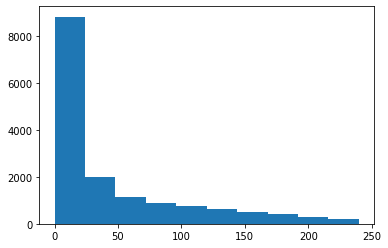

In [223]:
plt.hist(approved_under_an_hour)

### Closed pull requests

In [192]:
# Get all the events closing a PR
df_closed_prs = df_pull_request_event.where(df_pull_request_event['event_type'] == 'closed').dropna(subset=['_id'])
df_closed_prs.head(3)

,_id,pull_request_id,external_id,created_at,author_id,commit_sha,commit_repo_url,event_type,additional_data,commit_id
1,5ff188713fba52c925be892b,5ff1886f3fba52c925be8927,3202397715,2020-04-05 12:24:20,59bc22dcf2a4565fe9cfa0a7,NaN,NaN,closed,{'performed_via_github_app': None},NaN
18,5ff1887f3fba52c925be898a,5ff1887d3fba52c925be8978,1775164932,2018-08-07 12:39:03,5ff1887dc26a57681e7b6ee1,NaN,NaN,closed,{'performed_via_github_app': None},NaN
33,5ff188823fba52c925be89bb,5ff1887f3fba52c925be898c,1772018125,2018-08-06 05:18:53,5ff1887dc26a57681e7b6ee1,NaN,NaN,closed,{'performed_via_github_app': None},NaN


In [193]:
df_closed_prs__annotated_with_pr_creator = pd.merge(df_closed_prs, df_pull_request, on='pull_request_id')
df_closed_prs__annotated_with_pr_creator.columns

Index(['_id_x', 'pull_request_id', 'external_id_x', 'created_at_x',
       'author_id', 'commit_sha', 'commit_repo_url', 'event_type',
       'additional_data', 'commit_id', '_id_y', 'pull_request_system_id',
       'external_id_y', 'title', 'description', 'is_draft', 'is_locked',
       'author_association', 'created_at_y', 'updated_at', 'merged_at',
       'creator_id', 'linked_user_ids', 'requested_reviewer_ids', 'state',
       'labels', 'source_repo_url', 'source_branch', 'source_commit_sha',
       'target_repo_url', 'target_branch', 'target_commit_sha',
       'source_commit_id', 'target_commit_id', 'merge_commit_id',
       'assignee_id', 'lock_reason'],
      dtype='object')

In [194]:
# Get the PR's that were merged by someone that is not the same person as the one that opened the request
closed_pull_requests_closed_by_different_person = df_closed_prs__annotated_with_pr_creator.where(df_closed_prs__annotated_with_pr_creator['author_id'] != df_closed_prs__annotated_with_pr_creator['creator_id']).dropna(subset=['author_id', 'creator_id'])

closed_pull_requests_closed_by_different_person[['author_id', 'creator_id']]

,author_id,creator_id
0,59bc22dcf2a4565fe9cfa0a7,5ff1886fc26a57681e7b6cfe
7,59bc22dcf2a4565fe9cfa0a7,5ff18872c26a57681e7b6d2b
11,59bc22dcf2a4565fe9cfa0a7,59b9055bc335c776c30e850a
13,59bc22dcf2a4565fe9cfa0a7,5ff18872c26a57681e7b6d2b
14,59bc22dcf2a4565fe9cfa0a7,5ff18875c26a57681e7b6d68
...,...,...
46990,59bc22dcf2a4565fe9cfa0a7,5b6434e130a71b06bca36cd2
46991,5ff34a9dc26a57681ea38bf9,60fd84c6f73e2aa3902e825c
46992,59bc22dcf2a4565fe9cfa0a7,59bc1a03f2a4565fe9ce189c
46998,59bc22dcf2a4565fe9cfa0a7,59bc1a03f2a4565fe9ce189c


In [195]:
# Calculate the reivew time of closed pull requests
closed_pull_requests_closed_by_different_person['review_time_in_hours'] = (closed_pull_requests_closed_by_different_person.apply(lambda x: (x['created_at_x'] - x['created_at_y']).total_seconds() / 60 / 60 if x['created_at_x'] and x['created_at_y'] else None, axis=1))


In [196]:
closed_pull_requests_closed_by_different_person['review_time_in_hours'].describe()

count    31616.000000
mean      1090.622155
std       4119.100288
min          0.008611
25%         18.781181
50%         86.430139
75%        339.807569
max      69346.616111
Name: review_time_in_hours, dtype: float64

In [197]:
times = closed_pull_requests_closed_by_different_person['review_time_in_hours']
closed_05, closed_95 = times.quantile([0.05, 0.95])
closed_05, closed_95

(0.7643055555555556, 5312.072847222222)

In [198]:
# Filter really low values
closed_review_times = closed_pull_requests_closed_by_different_person.where(closed_pull_requests_closed_by_different_person['review_time_in_hours'] >= closed_05).dropna(subset=['review_time_in_hours'])[['review_time_in_hours']]

closed_review_times = closed_pull_requests_closed_by_different_person.where(closed_pull_requests_closed_by_different_person['review_time_in_hours'] <= closed_95).dropna(subset=['review_time_in_hours'])[['review_time_in_hours']]


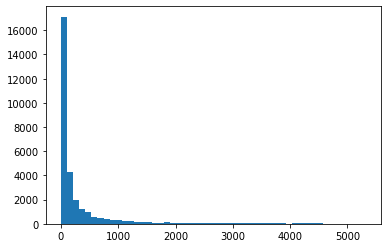

In [199]:
plot = plt.hist(x=closed_review_times, bins=50)

In [200]:
closed_review_times.describe()

,review_time_in_hours
count,30035.000000
mean,325.966631
std,705.852023
min,0.008611
25%,17.154028
50%,73.311944
75%,269.121944
max,5310.835000


In [201]:
mean_closed_review_time_in_days = round(closed_review_times.mean()[0] / 60)
mean_closed_review_time_in_days

5

In [202]:
print(f"Approved PR's take on average {mean_approved_review_time_in_days} days, whilst closed PR's take on average {mean_closed_review_time_in_days} days")

Approved PR's take on average 2 days, whilst closed PR's take on average 5 days
